# KALM Benchmark Analysis

This notebook provides comprehensive analysis of the KALM security scanner benchmark, including:
- Benchmark overview and statistics
- Scanner performance comparison
- Category-wise analysis
- Coverage and accuracy metrics

**KALM**: Kubernetes security scanner benchmark with 235+ intentionally vulnerable manifests across 12 security categories.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path

from kalm_benchmark.evaluation.evaluation import load_benchmark, Col

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📊 KALM Benchmark Analysis - Loading data...")

📊 KALM Benchmark Analysis - Loading data...


b'\x1b\x1b!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\x1b\x1b\n'
b'\x1b\x1b!!                                                                                                                      !!\x1b\x1b\n'
b'\x1b\x1b!!  This software has not been tested with node v24.5.0.                                                                !!\x1b\x1b\n'
b'\x1b\x1b!!  Should you encounter odd runtime issues, please try using one of the supported release before filing a bug report.  !!\x1b\x1b\n'
b'\x1b\x1b!!                                                                                                                      !!\x1b\x1b\n'
b'\x1b\x1b!!  This software is currently running on node v24.5.0.                                                                 !!\x1b\x1b\n'
b'\x1b\x1b!!  As of the current release of this software, supported node releases are:                                            !!\x1b

## 1. Benchmark Overview

Load and analyze the benchmark structure - categories, checks, and coverage.

In [ ]:
# Load benchmark data
df_bench = load_benchmark(with_categories=True)

print("📋 Benchmark Statistics:")
print(f"   Total checks: {len(df_bench)}")
print(f"   Categories: {df_bench['category'].nunique()}")
print(f"   Expected alerts: {(df_bench['expected'] == 'alert').sum()}")
print(f"   Expected passes: {(df_bench['expected'] == 'pass').sum()}")

# Display first few rows
df_bench.head()

📋 Benchmark Statistics:
   Total checks: 229
   Categories: 7
   Expected alerts: 197
   Expected passes: 32


,check_id,name,expected,description,path_to_check,category
0,RES-007-0,res-007-0-no-limitrange-object-for-namespace,alert,None,LimitRange.metadata.namespace,Reliability
1,RES-007-1,res-007-1-no-default-cpu-request-for-namespace,alert,None,LimitRange.spec.limits.defaultRequest.cpu|.spe...,Reliability
2,RES-007-2,res-007-2-no-default-cpu-limits-for-namespace,alert,None,LimitRange.spec.limits.default.cpu|.spec.limit...,Reliability
3,RES-007-3,res-007-3-no-cpu-limits-for-namespace,alert,None,LimitRange.spec.limits.min.cpu|LimitRange.spec...,Reliability
4,RES-008-1,res-008-1-no-default-memory-request-for-namespace,alert,None,LimitRange.spec.limits.defaultRequest.memory|....,Reliability


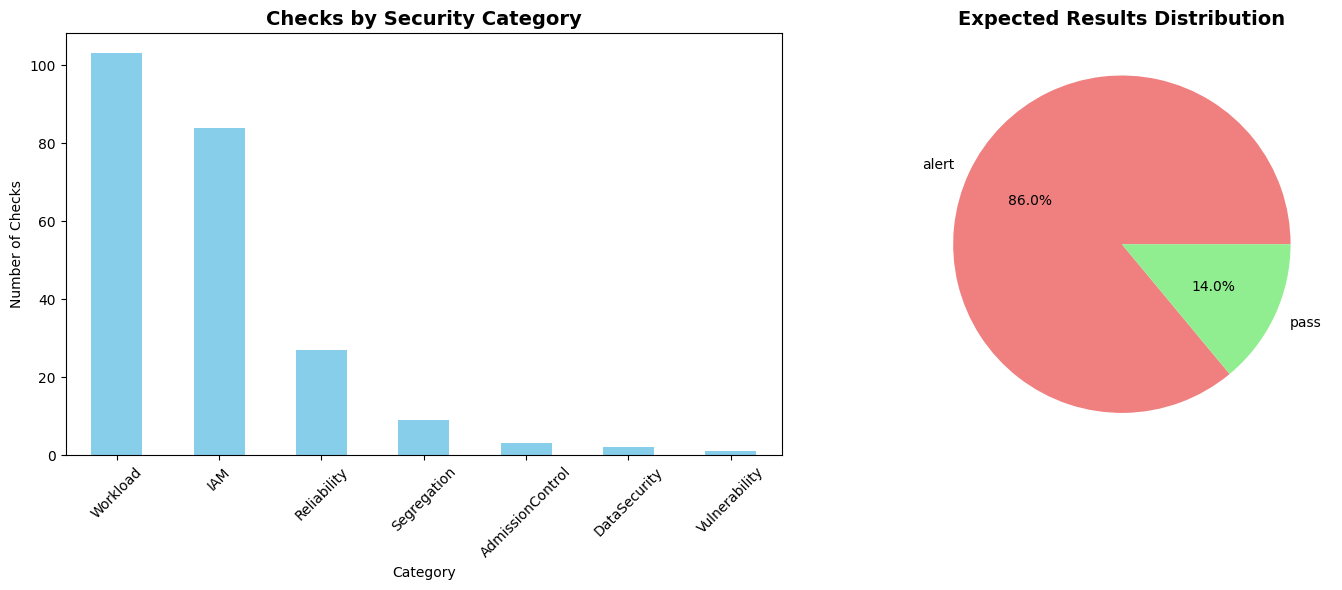


📊 Category Breakdown:
   Workload: 103 checks
   IAM: 84 checks
   Reliability: 27 checks
   Segregation: 9 checks
   AdmissionControl: 3 checks
   DataSecurity: 2 checks
   Vulnerability: 1 checks


In [3]:
# Category breakdown
category_stats = df_bench['category'].value_counts()

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Category distribution
category_stats.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Checks by Security Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Checks')
ax1.tick_params(axis='x', rotation=45)

# Expected result distribution  
expected_stats = df_bench['expected'].value_counts()
expected_stats.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
ax2.set_title('Expected Results Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n📊 Category Breakdown:")
for category, count in category_stats.items():
    print(f"   {category}: {count} checks")

## 2. Scanner Results Analysis

Analyze scanner performance from the database results.

In [4]:
# Connect to database and load scanner results
db_path = Path('../data/kalm.db')

if not db_path.exists():
    print("❌ Database not found. Run scanners first using: poetry run cli scan <scanner> -f manifests")
else:
    with sqlite3.connect(db_path) as conn:
        # Get scanner summary
        scanner_summary = pd.read_sql_query("""
            SELECT 
                scanner_name,
                COUNT(*) as total_results,
                COUNT(CASE WHEN severity IS NOT NULL AND severity <> '' THEN 1 END) as with_severity,
                ROUND(100.0 * COUNT(CASE WHEN severity IS NOT NULL AND severity <> '' THEN 1 END) / COUNT(*), 1) as severity_percentage,
                MAX(scan_timestamp) as latest_scan
            FROM scanner_results 
            GROUP BY scanner_name 
            ORDER BY total_results DESC
        """, conn)
        
        print(f"📊 Scanner Results Summary ({len(scanner_summary)} scanners):")
        print(scanner_summary.to_string(index=False))

📊 Scanner Results Summary (12 scanners):
scanner_name  total_results  with_severity  severity_percentage                latest_scan
   kubescape           4766           3781                 79.3 2025-08-27T13:23:19.205251
     polaris           4110           4110                100.0 2025-08-27T13:24:48.320601
  kube-score           3888           3888                100.0 2025-08-27T13:25:13.441952
  kubelinter           1199           1199                100.0 2025-08-27T13:23:29.688874
     kubesec            678            337                 49.7 2025-08-27T13:36:21.628908
       trivy            561            561                100.0 2025-08-27T13:23:59.682485
        kics            399            399                100.0 2025-08-27T13:23:42.966544
        snyk            208            208                100.0 2025-08-27T13:31:07.408232
  kube-bench            122             81                 66.4 2025-08-27T13:28:01.667682
   terrascan             87             87       

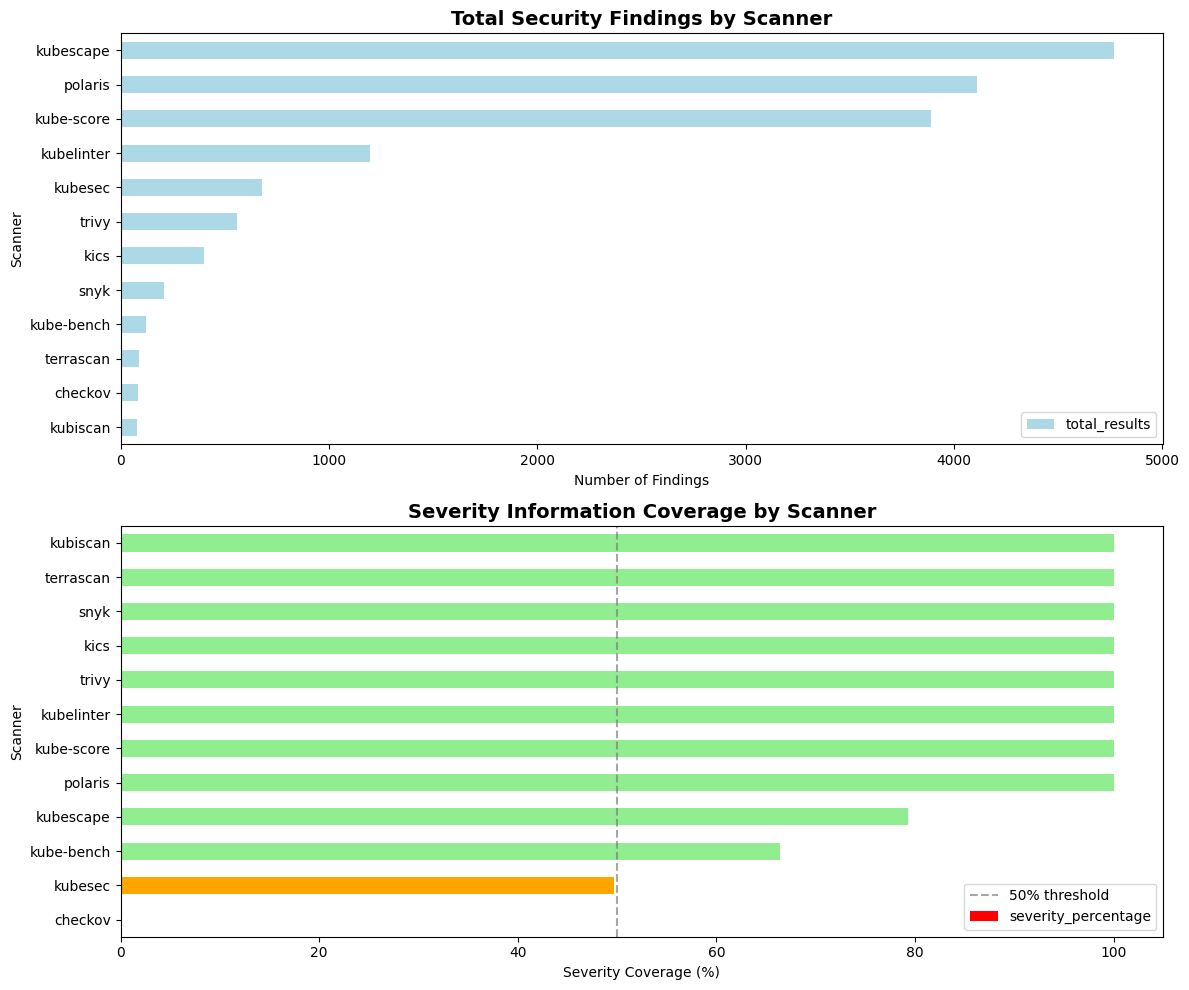

In [5]:
if db_path.exists():
    # Visualize scanner performance
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Total results by scanner
    scanner_summary_sorted = scanner_summary.sort_values('total_results', ascending=True)
    scanner_summary_sorted.plot(x='scanner_name', y='total_results', kind='barh', ax=ax1, color='lightblue')
    ax1.set_title('Total Security Findings by Scanner', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Findings')
    ax1.set_ylabel('Scanner')
    
    # Severity coverage percentage
    severity_sorted = scanner_summary.sort_values('severity_percentage', ascending=True)
    colors = ['red' if x == 0 else 'orange' if x < 50 else 'lightgreen' for x in severity_sorted['severity_percentage']]
    severity_sorted.plot(x='scanner_name', y='severity_percentage', kind='barh', ax=ax2, color=colors)
    ax2.set_title('Severity Information Coverage by Scanner', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Severity Coverage (%)')
    ax2.set_ylabel('Scanner')
    ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.7, label='50% threshold')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## 3. Detailed Check Analysis

Analyze check variants and create improved categorization.

In [6]:
# Helper functions for analysis
def get_base_check_id(check_id: str) -> str:
    """Extract base check ID from variant (e.g., POD-003-1 -> POD-003)"""
    if check_id.count('-') <= 1:
        return check_id
    base_id, variant = check_id.rsplit("-", maxsplit=1)
    return base_id

def get_pretty_name(row: pd.Series) -> str:
    """Generate human-readable check name"""
    name = row[Col.Name].replace(f"{row[Col.CheckId].lower()}-", "")
    return name.replace("-", " ").title()

# Add derived columns
df_bench['base_check_id'] = df_bench['check_id'].map(get_base_check_id)
df_bench['pretty_name'] = df_bench.apply(get_pretty_name, axis=1)

print("✅ Added base check IDs and pretty names")
df_bench[['check_id', 'base_check_id', 'pretty_name', 'category']].head()

✅ Added base check IDs and pretty names


,check_id,base_check_id,pretty_name,category
0,RES-007-0,RES-007,No Limitrange Object For Namespace,Reliability
1,RES-007-1,RES-007,No Default Cpu Request For Namespace,Reliability
2,RES-007-2,RES-007,No Default Cpu Limits For Namespace,Reliability
3,RES-007-3,RES-007,No Cpu Limits For Namespace,Reliability
4,RES-008-1,RES-008,No Default Memory Request For Namespace,Reliability


In [ ]:
# Create overview by category and base check
df_overview = df_bench.groupby(['category', 'base_check_id']).agg({
    'pretty_name': 'first',
    'check_id': 'count',
    'expected': lambda x: (x == 'alert').sum()
}).rename(columns={
    'pretty_name': 'name', 
    'check_id': 'num_variants',
    'expected': 'alert_variants'
})

print("Benchmark Overview by Category:")
print(f"\nTotal base checks: {len(df_overview)}")
print(f"Total check variants: {df_overview['num_variants'].sum()}")
print("\nVariants by category:")
category_variants = df_overview.groupby(level=0)['num_variants'].sum().sort_values(ascending=False)
for category, variants in category_variants.items():
    base_checks = len(df_overview.loc[category])
    print(f"   {category}: {variants} variants across {base_checks} base checks")

📊 Benchmark Overview by Category:

Total base checks: 75
Total check variants: 229

Variants by category:
   Workload: 103 variants across 30 base checks
   IAM: 84 variants across 19 base checks
   Reliability: 27 variants across 13 base checks
   Segregation: 9 variants across 7 base checks
   AdmissionControl: 3 variants across 3 base checks
   DataSecurity: 2 variants across 2 base checks
   Vulnerability: 1 variants across 1 base checks


🔍 Most Complex Checks (Most Variants):
   POD-035: Using Insecure Capability Audit Write (22 variants) - Workload
   POD-017: Use Runasnonroot Flag On Pod (9 variants) - Workload
   POD-003: Automount Serviceaccounttoken By Default (9 variants) - Workload
   POD-024: Usage Of Bin Bash In Container (9 variants) - Workload
   RBAC-020: Role Manages Rbac (8 variants) - IAM
   RBAC-004: Role Creates Pods (8 variants) - IAM
   RBAC-010: Role Manages Rbac (8 variants) - IAM
   RBAC-021: Only Admins Should Be Able To Create Persistent Volumes (6 variants) - IAM
   RBAC-012: Role Info Disclosure (6 variants) - IAM
   RBAC-002: Read Access To Secrets (6 variants) - IAM


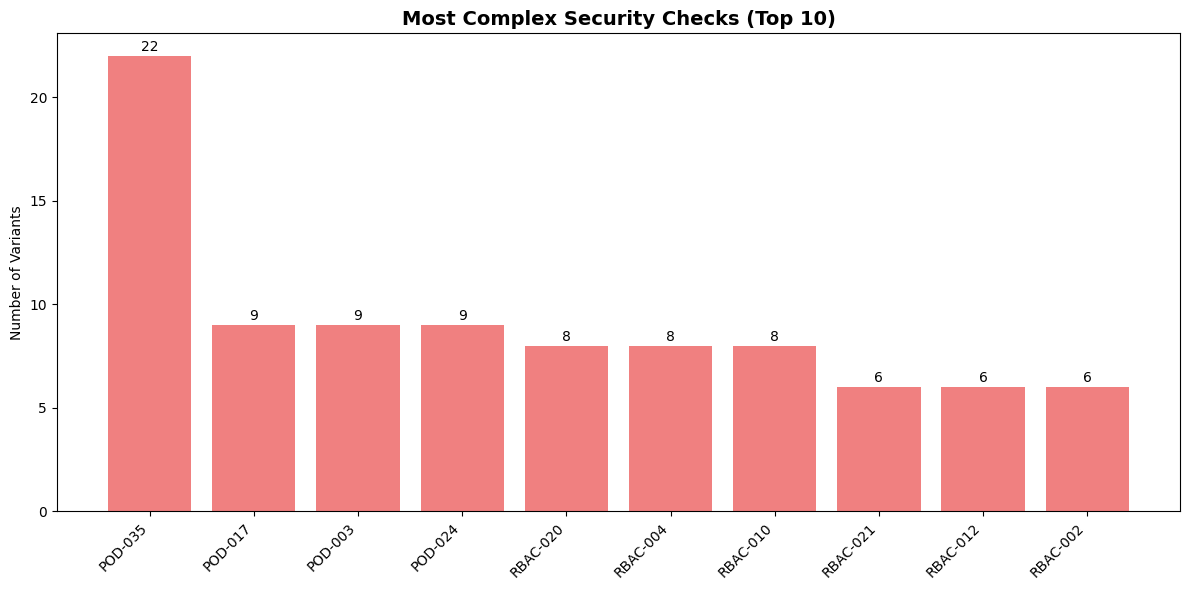

In [ ]:
# Most complex checks (most variants)
complex_checks = df_overview.sort_values('num_variants', ascending=False).head(10)

print("Most Complex Checks (Most Variants):")
for (category, check_id), row in complex_checks.iterrows():
    print(f"   {check_id}: {row['name']} ({row['num_variants']} variants) - {category}")

# Visualize complexity
fig, ax = plt.subplots(figsize=(12, 6))
complex_checks_plot = complex_checks.reset_index()
bars = ax.bar(range(len(complex_checks_plot)), complex_checks_plot['num_variants'], color='lightcoral')

# Add check IDs as labels
ax.set_xticks(range(len(complex_checks_plot)))
ax.set_xticklabels(complex_checks_plot['base_check_id'], rotation=45, ha='right')
ax.set_ylabel('Number of Variants')
ax.set_title('Most Complex Security Checks (Top 10)', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 4. Security Impact Analysis

Analyze the security impact and distribution of different check types.

In [ ]:
# Security impact analysis by category
security_impact = df_bench.groupby(['category', 'expected']).size().unstack(fill_value=0)

# Calculate alert ratio
security_impact['alert_ratio'] = security_impact['alert'] / (security_impact['alert'] + security_impact.get('pass', 0))
security_impact['total_checks'] = security_impact['alert'] + security_impact.get('pass', 0)

print("Security Impact by Category:")
impact_summary = security_impact.sort_values('alert_ratio', ascending=False)
for category, row in impact_summary.iterrows():
    alerts = int(row['alert'])
    total = int(row['total_checks'])
    ratio = row['alert_ratio'] * 100
    print(f"   {category}: {alerts}/{total} checks expect alerts ({ratio:.1f}%)")

🔐 Security Impact by Category:
   AdmissionControl: 3/3 checks expect alerts (100.0%)
   DataSecurity: 2/2 checks expect alerts (100.0%)
   IAM: 84/84 checks expect alerts (100.0%)
   Segregation: 9/9 checks expect alerts (100.0%)
   Vulnerability: 1/1 checks expect alerts (100.0%)
   Workload: 79/103 checks expect alerts (76.7%)
   Reliability: 19/27 checks expect alerts (70.4%)


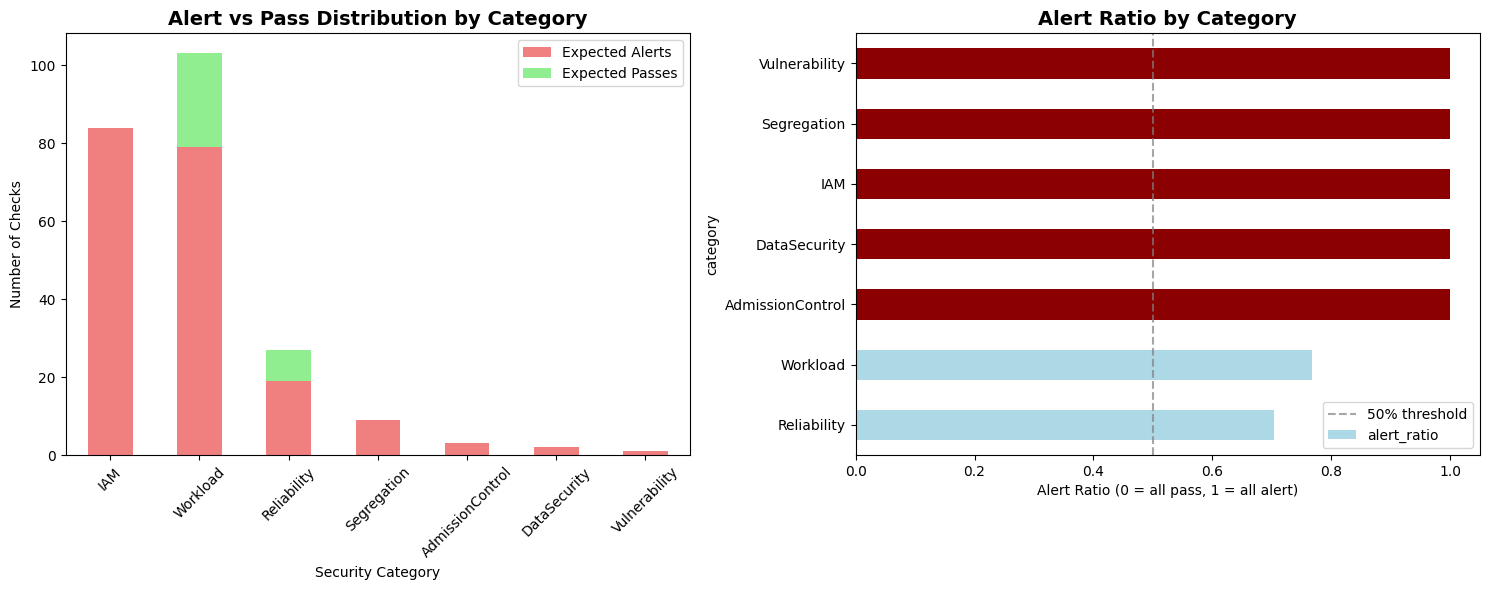

In [10]:
# Visualize security impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart of alert vs pass by category
impact_plot = security_impact[['alert', 'pass']].sort_values('alert', ascending=False)
impact_plot.plot(kind='bar', stacked=True, ax=ax1, color=['lightcoral', 'lightgreen'])
ax1.set_title('Alert vs Pass Distribution by Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Security Category')
ax1.set_ylabel('Number of Checks')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Expected Alerts', 'Expected Passes'])

# Alert ratio by category
ratio_plot = security_impact['alert_ratio'].sort_values(ascending=True)
colors = ['darkred' if x == 1.0 else 'orange' if x > 0.8 else 'lightblue' for x in ratio_plot]
ratio_plot.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Alert Ratio by Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Alert Ratio (0 = all pass, 1 = all alert)')
ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='50% threshold')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Export Analysis Results

Generate summary tables for documentation and reporting.

In [ ]:
# Create LaTeX table for documentation
latex_summary = df_overview.reset_index()
latex_summary = latex_summary.groupby('category').agg({
    'base_check_id': 'count',
    'num_variants': 'sum',
    'alert_variants': 'sum'
}).rename(columns={
    'base_check_id': 'base_checks',
    'num_variants': 'total_variants',
    'alert_variants': 'alert_variants'
})

# Add totals row
latex_summary.loc['TOTAL'] = latex_summary.sum()

print("KALM Benchmark Summary Table:")
print(latex_summary.to_string())

# Generate LaTeX version
print("\nLaTeX table for documentation:")
print(latex_summary.to_latex(
    caption="KALM Benchmark Overview: Security Categories and Check Distribution",
    label="tbl:kalm-benchmark-overview",
    column_format="lrrr"
))

📊 KALM Benchmark Summary Table:
                  base_checks  total_variants  alert_variants
category                                                     
AdmissionControl            3               3               3
DataSecurity                2               2               2
IAM                        19              84              84
Reliability                13              27              19
Segregation                 7               9               9
Vulnerability               1               1               1
Workload                   30             103              79
TOTAL                      75             229             197

📄 LaTeX table for documentation:
\begin{table}
\caption{KALM Benchmark Overview: Security Categories and Check Distribution}
\label{tbl:kalm-benchmark-overview}
\begin{tabular}{lrrr}
\toprule
 & base_checks & total_variants & alert_variants \\
category &  &  &  \\
\midrule
AdmissionControl & 3 & 3 & 3 \\
DataSecurity & 2 & 2 & 2 \\
IAM & 19 & 84

In [ ]:
# Save processed data for other analyses
output_dir = Path('../data/analysis')
output_dir.mkdir(exist_ok=True)

# Save key datasets
df_bench.to_csv(output_dir / 'benchmark_detailed.csv', index=False)
df_overview.to_csv(output_dir / 'benchmark_overview.csv')
if 'scanner_summary' in locals():
    scanner_summary.to_csv(output_dir / 'scanner_summary.csv', index=False)

print(f"Analysis results saved to {output_dir}:")
for file in output_dir.glob('*.csv'):
    print(f"   {file.name}")

💾 Analysis results saved to ../data/analysis:
   benchmark_overview.csv
   benchmark_detailed.csv
   scanner_summary.csv


## Summary

This analysis provides a comprehensive overview of the KALM benchmark:

- **235+ security checks** across 12 major categories
- **Workload security** is the largest category with complex multi-variant checks
- **IAM/RBAC** has the most comprehensive coverage of permission scenarios  
- Most checks expect **alert** results, validating security misconfiguration detection
- Scanner performance varies significantly in **total findings** and **severity coverage**